<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2019/sem_6/student_teacher_dist.png" height="300" width="700"> 
</center>

# <center> R для тервера и матстата. <br>  <br>  Важные штуки про тестирование гипотез. </center>



Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2019). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/r_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

---------

В прошлой тетрадке мы поговорили о том, как можно проверять гипотезы о долях, средних и дисперсиях с помощью параметрических тестов. В этой тетрадке мы попробуем обсудить ещё несколько важных моментов, сопряжённых с тестами. План будет следующим: 

In [12]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

## Agenda 

- Ещё разок про тест отношения правдоподобий

- Бутстрэп

- Множественная проверка гипотез

## Способы проверить гипотезу

- Параметрические критерии 

- Непараметрические критерии

- Тест отношения правдоподобий 

- Бутстрэп 

Мы уже говорили про тест отношения правдоподобий в прошлый раз, но вы все были в этот момент опустошены, поэтому давайте обсудим его ещё разок. 

# 1. Критерий отношения правдоподобий

</br> 

__Шаг первый:__ оценили модель методом максимального правдоподобия без ограничений и получили $L(\hat \theta_{ML})$

</br>

__Шаг второй:__ оценили модель, наложив ограничение и получили $L(\hat \theta_{0})$

</br>

Оказывается, что 

$$
LR = 2\cdot(\ln L(\hat \theta_{ML}) - \ln L(\theta_0)) \sim \chi^2_q,
$$
где $q$ — число ограничений

### Пример первый

</br>

Пусть $X_1, \ldots, X_{30} \sim iid \hspace{1mm} Pois(\lambda)$ — количество серий ИП, которое смотрит Ульяна каждый день. Получилось, что $\sum X_i = 100$. Нужно проверить гипотезу о том, что 

$$
H_0: \lambda = 2 \\
H_A: \lambda \ne 2
$$

$$ 
lnL = \sum x_i \ln \lambda - n \lambda
$$

$$
\hat{\lambda}^{ML} = \bar x = \frac{10}{3}
$$

$$
LR = 2\cdot(\ln L(\hat \theta_{ML}) - \ln L(\theta_0)) \sim \chi^2_q,
$$

In [4]:
lnL <- function(l){
    return(100*log(l) - 30*l)
  }

2*(lnL(10/3) - lnL(2))  # наблюдаемое значение
qchisq(0.95, df=1)      # критическое значение

[1] 22.16512

[1] 3.841459

In [ ]:
## Пример второй 

В [табличке](https://yadi.sk/i/hDxMJ0fw3VSDmu) лежит информация о стоимости квартир в Москве и о основных параметрах этих квартир. Пусть цена на квартиры имеет логарифмически нормальное распределение. Оцените параметры $\mu$ и $\sigma$ методом максимального правдоподобия. Постройте для оценок доверительные интервалы. 


```{r, echo = FALSE}
df = read.csv('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/flat.csv', sep='\t') 

head(df)
```



## Пример второй 

```{r, results = 'hold'}

x = log(df$price)

lnL <- function(param,data) {
  n <- length(data)
  result <- -n/2*log(2*pi)-n/2*log(param[2]^2)-sum((data-param[1])^2)/(2*param[2]^2)
  return(result)
}

library('maxLik') 

res <- maxLik(lnL, start=c(0.1,0.1),data=x)
summary(res)

```


## Пример второй 

```{r, results = 'hold'}

#lnL_res <- function(sigma,data) lnL(c(5,sigma),x)
#res_restr <- maxLik(lnL_res, start=0.1,data=x)
#summary(res_restr)
#par_restr <- c(5, res_restr$estimate)

#2*(lnL(par, x) - lnL(par_restr, x))
#qchisq(0.975, df=1)
```


## Критерии максимальной мощности 

- В примерах выше мы сравнивали $\frac{L_{ML}}{L_R}$ с единицей

- На основе этого мы делали вывод насколько сильно различаются два правдоподобия и решали что делать с гипотезой

- Сравнивать отношение правдоподобий можно не с единицей, а с какой-то константой $c$

- Лемма Неймана-Пирсона утверждает, что можно подобрать $c$ таким, чтобы у критерий была максимальная мощность (это было на лекции)

- Подробнее смотри в Черновой страницы 86-67





# 2. Бутсрап


__Бутстрап__ - это метод оценки статистик сложных распределений. Часто возникает необходимость проверить гипотезу о какой-то очень неудобной статистике, распределение которой неизвестно или построить для неё доверительный интервал. 

Чтобы сделать это, надо придумать как распределение этой статистики получить. Мы с вами уже знаем два способа сделать это. 

Способ номер один называется параметрическим. Мы предполагаем, что генеральная совокупность имеет какое-то распределение. Мы можем даже проверить гипотезу об этом с помощью какого-нибудь критерия. После мы на основе этого распределения можем придумать адекватную случайную величину для проверки гипотезы. Именно так мы поступали раньше. Иногда такую случайную величину придумать сложно или вовсе невозможно. Например, поди придумай адекватный критерий для медианы или моды. К тому же не очень понятно из каких соображений выбирать семейство распределений для проверки гипотезы, так как про данные ничего неизвестно. Другим способом был тест отношения правдоподобий. Пришло время познакомиться с третьим методом.

Он говорит следующее: давайте извлечём из генеральной совокупности какое-то количество выборок, посчитаем по ним нашу статистику, для которой доверительный интервалы мы хотим получить, а потом оценим эмпирически её выборочное распределение и на его основе получим доверительные интервалы. Этот способ применим скорее в теории, чем на практике. Если мы можем генерировать бесконечное число выборок из генеральной совокупности, то для нас незатруднительно посчитать истинное значение интересующих нас параметров.  

Эти мысли подводят нас к идее бутстрапа. В нашем распоряжении есть выборка. Давайте сделаем вид, что она и есть генеральная совокупность и будем извлекать из неё с повторением элементы. На основе получившихся подвыборок мы можем оценить всё, что нашей душе угодно. Поначалу такое кажется безумием, но это реально работает. И есть даже несколько теорем, которые доказывают почему это работает и как нужно правильно делать это в сложных ситуациях. 

Опишем бутстрап чуть более формально. Пусть имеется выборка $X$ размера $N$. Равномерно возьмём из выборки $N$ объектов с возвращением. Это означает, что мы будем $N$ раз выбирать произвольный объект выборки (считаем, что каждый объект достаётся с одинаковой вероятность $\frac{1}{N}$), причём каждый раз мы выбираем из всех исходных $N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Конечно же из-за возвращения среди них окажутся повторы. 

Обозначим новую выборку через $X_1$. Повторяя процедуру $B$ раз, сгенерируем $B$ подвыборок $X_1, \ldots, X_B$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.



![](https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_7/7.1%20presa_AB/bootstrap.png)

![](https://hsto.org/getpro/habr/post_images/198/14a/3f7/19814a3f7efaa3b7d1a3f8ab35889832.jpg)

По изначальной выборке мы могли посчитать всего одну статистику. По сгенерированным подвыборкам мы можем посчитать $B$ статистик и увидеть как наша неизвестная статистика распределена. Скорее всего, вам кажется это сложным. Давайте попробуем посмотреть на конкретный пример. Возможно, станет легче. Но это неточно. 

## Проблема 

Verizon — основная региональная телекоммуникационная компания (Incumbent Local Exchange Carrier, ILEC) в западной 
части США. В связи с этим данная компания обязана предоставлять сервис ремонта телекоммуникационного оборудования 
не только для своих клиентов, но и для клиентов других локальных телекоммуникационых компаний (Competing Local Exchange Carriers, CLEC). При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, Verizon может быть оштрафована. 

Проверим правда ли время на ремонт своего оборудования существенно ниже чем время на ремонт других компаний.

In [13]:
library('dplyr')
library('rio') # тут import, который сам догадается до разделителей и даже excel прочтёт

df = import('/Users/fulyankin/Yandex.Disk.localized/R/R_prob_data/verizon.csv')
# ILEC - внутренний клиент 
# CLEC - внешние клиенты 
head(df)

Time,Group
17.50,ILEC
2.40,ILEC
0.00,ILEC
0.65,ILEC
22.23,ILEC
1.20,ILEC


* В выборке имеется сильный перекос в наблюдениях. 

In [23]:
df %>% group_by(Group) %>% summarise(count = n(), mean = mean(Time), median = median(Time))

Group,count,mean,median
CLEC,23,16.509130,14.33
ILEC,1664,8.411611,3.59


* В выборке есть выбросы. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


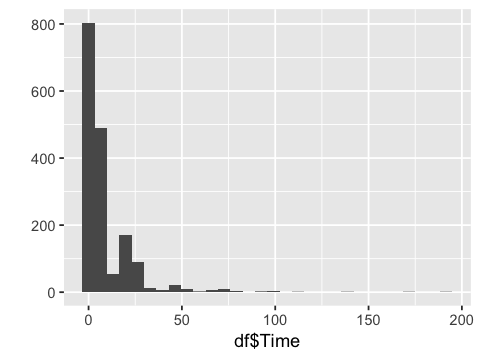

In [15]:
qplot(df$Time)

Из-за этого средние будут не очень адекватной оценкой для типичного представителя выборки. Используя их, мы будем искуственно находиться на стороне компании. Поэтому гораздо уместнее сформулировать в терминах медиан, так как они нечувствительны к выбросам в отличие от средних. 

$$
\begin{aligned}
&H_0: \hspace{2mm} med_1 = med_2 \\
&H_1: \hspace{2mm} med_1 > med_2
\end{aligned}
$$

Беда в том, что для медиан как раз у нас нет хорошей статистики. Это весомый повод прибегнуть к бустрапу!

In [38]:
df %>% sample_n(size = 3, replace=TRUE)

Time,Group
3.58,ILEC
5.02,ILEC
4.38,ILEC


Сделали подвыборку размера $3$ с повторениями, потом по ней можно что-нибудь посчитать. Например, медианы. Закодим бустрап в виде двух функций. Первая будет делать `B_sample` выборок.

In [103]:
get_bootstrap_samples <- function(data, B_sample){
    samples = list() # лист, куда мы будем записывать выборки
    
    for(i in 1:B_sample){
        # генерируем выборки с повторениями соответствующую по размерам оригинальной  
        # и записываем её в лист
        samples[[i]] = sample(data, size = length(data), replace=TRUE)
        }
    return(samples)
    }

In [94]:
# неколько сбустрапированных выборк
# get_bootstrap_sample(df$Time, 3)

Вторая функция будет искать квантили сгерированого распределения. 

In [104]:
stat_intervals <- function(stat, alpha){
    return(quantile(stat, c(alpha/2,(1-alpha/2)), name = FALSE))
    }

Отделим данные по внутренним и внешним клиентам друг от друга и построим доверительные интервалы для каждой из медиан. Будем бустрапировать $1000$ выборок. 

In [125]:
ilec = df %>% filter(Group == 'ILEC')
clec = df %>% filter(Group == 'CLEC')

# Делаем 1000 выборок для первой таблички и считаем по каждой медиану 
# функция lapply применяет функцию median к каждой выборке 
# команда as.numeric сделает листы векторами

clec_median_scores = as.numeric(lapply(get_bootstrap_samples(clec$Time, 10000), median))
ilec_median_scores = as.numeric(lapply(get_bootstrap_samples(ilec$Time, 10000), median))

Смотрим на итоговые доверительный интервалы. 

In [126]:
cat("95% confidence interval for the ILEC median repair time:", stat_intervals(ilec_median_scores, 0.05),'\n')
cat("95% confidence interval for the CLEC median repair time:", stat_intervals(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: 3.22 3.84 
95% confidence interval for the CLEC median repair time: 5.45 20

По аналогии найдём доверительный интервал для разности медиан. 

In [127]:
delta_median_scores = clec_median_scores - ilec_median_scores
cat("95% confidence interval for the diff median repair time:", stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the diff median repair time: 2.02 16.66

Оценим вероятность того, что разность больше нуля. 

In [128]:
sum(delta_median_scores > 0)/length(delta_median_scores)

[1] 0.9987

Кажется, команию пришло время оштрафовать. Ещё один пример на бустрап мы посмотрим в тетрадке с поющими котами ближе к концу пары. 

№

# 3. Последовательная проверка гипотез 

## История про Зомби-лосося

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_7/6.2%20presa%20-%20bootstrap%2C%20LR/losos.jpg" width="600"> 
</center>

## История про Зомби-лосося

- В 2012 году ряд авторов получил шнобелевскую премию по нейробиологии

- Нужно было протестировать аппарат МРТ, обычно для этого берут шарик с маслом и сканируют его 

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_7/6.2%20presa%20-%20bootstrap%2C%20LR/mrt.jpg" width="400"> 
</center>

## История про Зомби-лосося

- Скучно, купили мёртвого лосося

- Стали показывать ему фотки людей

- Задача показать, что в голове лосося нет мозговой активности 

- Аппарат МРТ возвращает кучу данных. Один объект - воксель. Для исследования активности мозга в целом, надо провести множественное тестирование гипотез относительно каждого вокселя.

- Оказалось, что у лосося есть рекация в мозгу на людей, написали [статью](http://prefrontal.org/files/posters/Bennett-Salmon-2009.pdf)

## Проверка гипотезы 

__Уровень значимости:__  $P(\text{отвергнуть} H_0 \mid H_0 \text{верна}) = \alpha$ 

__Выборка:__ $X_1, \ldots, X_n \sim iid \hspace{1mm} F_X(x, \theta)$

__Нулевая гипотеза:__ $H_0 : \theta = \theta_0 $ 

__Альтернатива:__ $H_1 : \theta \ne \theta_0 $ 

__Статистика:__ $T(X_1, \ldots, X_n)$

Если $p$-значение $< \alpha$, гипотеза отвергается 

## Две гипотезы 

- Гипотеза сразу о двух параметрах 

- Всё усложняется: можно ошибиться в обеих гипотезах, ошибиться только в первой или только во второй

- Накопление вероятности ошибки первого рода 

$$
P(\text{ошибочно отвергнуть } H_0 ) = P(\text{ошибочно отвергнуть хотя бы одну из гипотез}) \le \\
\le P(\text{ошибка в первой}) + P(\text{ошибка во второй}) = \alpha + \alpha = 2\alpha
$$

## Рецепт лечения 

- Будем проверять каждую из двух гипотез на уровне значимости $\frac{\alpha}{2}$

- Если гипотез $K$, то каждую проверяем на уровне $\frac{\alpha}{K}$

- Такой подход называется __поправкой Бонферрони__

## Разрешение парадокса о лососе

- Если ввести поправку Бонферрони, мёртвый лосось остаётся мёртвым

- Реальный вклад в науку, анализ работ по нйробиологии до 2010 года показал, что окло 40% не используют поправку при множественном тестировании гипотез

- После публикации количество статей, где его не используют упало до 10%

## Проблема: 

Говорят, Джордж Р.Р. Мартин, автор цикла ``Песнь Льда и Огня'', истребляет Старков: чаще ``убивает'' персонажей, относящихся к этому дому, чем персонажей других домов. В таблице ниже приведено количество персонажей, относящихся к тому или иному дому, упомянутых за первые $4$ книги, а так же количество погибших персонажей.

| Дом | Упомянутые персонажи | Погибшие персонажи |
|-----|---------------------|------|
|House Stark	| 72 | 18 |
|House Lannister | 49 | 11 |
|House Greyjoy | 41 | 12 |
|Night's Watch |105 | 41 |


Данные взяты из [датасета по ссылке.](https://www.kaggle.com/mylesoneill/game-of-thrones) Нужно проверить гипотезу об этом на $5\%$ уровне значимости. 

## Формализация задачи

Нам нужно проверить гипотезу о том, что доля смертей среди старков совпадает со всеми остальными долями против альтернативы, что хотя бы в одной из ситуаций смертность в доме Старков больше:

\begin{equation*}
\begin{aligned} 
H_0: p_1 = p_2 \\
H_1: p_1 > p_2 
\end{aligned}
\end{equation*}

Протестируем все гипотезы без коррекции на множественное тестирование, а потом введём её. 

In [129]:
n_st = 72 
m_st = 18

n_lan = 49
m_lan = 11

n_gr = 41
m_gr = 12 

n_nw = 105
m_nw = 41 

alpha = 0.05

Закодим тест для проверки гипотезы о равенстве долей в виде двух функций. Одна будет считать значение статистики, вторая находить `p_value`. 

In [141]:
proportions_diff_zstat = function(n1, m1, n2, m2){ 
    p1 = m1/n1
    p2 = m2/n2
    P = (p1*n1 + p2*n2)/(n1 + n2)
    z_stat = (p1 - p2)/sqrt(P * (1-P) * (1/n1 + 1/n2))
    return(z_stat)
}

proportions_diff_ztest = function(z_stat, alternative = 'two-sided'){
    if(alternative == 'two-sided'){
        return(2 * (1 - pnorm(np.abs(z_stat))))
    }
    
    if(alternative == 'less'){
        return(pnorm(z_stat))
    }
    
    if(alternative == 'greater'){
        return(1 - pnorm(z_stat))
    }
}

Проверяем три гипотезы! 

In [145]:
# Для всех трёх случаев гипотеза о рпвенстве долей не отвергается. 
proportions_diff_ztest(proportions_diff_zstat(n_st, m_st, n_gr, m_gr),'greater')
proportions_diff_ztest(proportions_diff_zstat(n_st, m_st, n_lan, m_lan),'greater')
proportions_diff_ztest(proportions_diff_zstat(n_st, m_st, n_nw, m_nw),'greater')

[1] 0.6893569

[1] 0.3734671

[1] 0.9742641

Чтобы ввести коррекцию Бонферони, будем сравнивать с $\frac{\alpha}{3}$. 

## Другие поправки 

- Поправку Бонферрони очень просто применять, но у такой процедуры низкая мощность 

- Можно улучшить её, если брать $\alpha_i$ разными 

## Нисходящие методы 

- Отсортируем полученные p-значения 

$$
p_{(1)} \le p_{(2)} \le \ldots \le p_{(m)}
$$
- Если $p_{(1)} \ge \alpha_1$, не отвергаем все нулевые гипотезы, иначе отвергаем $H_{(1)}$ и продолжаем 

- Если $p_{(2)} \ge \alpha_2$, не отвергаем все нулевые гипотезы, иначе отвергаем $H_{(2)}$ и продолжаем 

- Делаем так, пока не закончатся гипотезы

## Метод Холма 

Если взять уровни значимости 

$$\alpha_1 = \frac{\alpha}{m}, \alpha_2 = \frac{\alpha}{m-1}, \ldots, \alpha_i = \frac{\alpha}{m-i+1}, \ldots, \alpha_m = \alpha$$ 
мы получим __метод холма.__ 

# 4. Ошибки первого и второго рода 